### GAN

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [23]:
def del_no_pump_index(df):
    """
    Deletes the rows where the pump is not running
    """
    # df = pd.read_csv('labeled_features/features_' + time_freq + '.csv', parse_dates=['date'])
    # 将第一个列设为索引
    orginal = df.shape[0]

    # 找出没有被pump的pump_index
    pump_index = df['pump_index'].unique()
    nopump_index = []
    nopump_symbol = []
    for i in pump_index:
        df_pump = df[df['pump_index'] == i]
        # 如果df_pump的列gt不存在等于1, 打印i
        if 1 not in df_pump['gt'].values:
            nopump_symbol.append(df_pump['symbol'].unique().tolist()[0])
            nopump_index.append(i)
    print('nopump_index: ', nopump_index)
    print('nopump_symbol: ', nopump_symbol)

    print('df.shape: ', df.shape)
    print(df['pump_index'].unique().shape)

    # 删除pump_index的值等于48的行
    for i in nopump_index:
        df = df.drop(df[df['pump_index'] == i].index)

    print('df_cleaned.shape: ', df.shape)
    print(df['pump_index'].unique().shape)
    now = df.shape[0]
    print('deleted: ', orginal - now)
    return df

In [24]:
# 划分数据集
def split_dataset(time_freq):
    df = pd.read_csv('labeled_features/features_' + time_freq + '.csv', parse_dates=['date'])

    features = ['std_rush_order',
                'avg_rush_order',
                'std_trades',
                'std_volume',
                'avg_volume',
                'std_price',
                'avg_price',
                'avg_price_max',
                'hour_sin',
                'hour_cos',
                'minute_sin',
                'minute_cos']

    df = del_no_pump_index(df)
    X = df[features]
    Y = df['gt'].astype(int).values.ravel()

    # normalize
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # normal data
    X_normal = X[Y == 0]
    Y_normal = Y[Y == 0]

    # abnormal data
    X_abnormal = X[Y == 1]
    Y_abnormal = Y[Y == 1]

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X_normal, Y_normal, test_size=0.2, random_state=2023)
    
    # 拼接X_test和X_abnormal
    X_test = np.concatenate((X_test, X_abnormal), axis=0)
    y_test = np.concatenate((y_test, Y_abnormal), axis=0)

    # # 将时间序列数据转换为适用于LSTM自编码器的输入格式
    # X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    # X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    return X_train, X_test, y_train, y_test

from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
def pick_threshold(y, preds):
    thresholds = np.linspace(1, 100, 500)
    f1_scores = [f1_score(y, preds > t) for t in thresholds]
    precision_scores = [precision_score(y, preds > t) for t in thresholds]
    recall_scores = [recall_score(y, preds > t) for t in thresholds]
    plt.figure(figsize=(12, 6))
    plt.plot(thresholds, f1_scores, label='F1 Score')
    plt.plot(thresholds, precision_scores, label='Precision')
    plt.plot(thresholds, recall_scores, label='Recall')
    plt.axvline(x=thresholds[np.argmax(f1_scores)], color='r', linestyle='--', label='Max F1 Score')
    plt.title('F1 Score w.r.t varying threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()
    best_threshold = thresholds[np.argmax(f1_scores)]
    print('Best threshold: ', best_threshold)
    print('Best F1 Score: ', np.max(f1_scores))
    print('Recall: ', recall_score(y, preds > best_threshold))
    print('Precision: ', precision_score(y, preds > best_threshold))
    

    cm = confusion_matrix(y, preds > best_threshold)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('LSTM-AutoEncoder - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    return best_threshold

In [25]:
from keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
from keras.models import Model, Sequential
from keras import models
from keras.optimizers import Adam
import tensorflow as tf

# Define the Autoencoder generator
def build_generator(input_dim, output_dim):
    input_layer = Input(shape=(input_dim,))
    x = Dense(32            
            #, use_bias=False
            )(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Dense(16)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Dense(16)(x)
    x = BatchNormalization()(x) 
    x = LeakyReLU(0.2)(x)

    x = Dense(32)(x)
    x = BatchNormalization()(x) 
    x = LeakyReLU(0.2)(x)

    output_layer = Dense(output_dim)(x)
    generator = Model(input_layer, output_layer, name='generator')
    # generator.summary()
    return generator

# Define the Discriminator
def build_discriminator(input_dim):
    input_layer = Input(shape=(input_dim,))
    x = Dense(32
            #, use_bias=False
            )(input_layer)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)

    x = Dense(64)(x)
    x = LeakyReLU(0.2)(x)
    x= Dropout(0.3)(x)

    output_layer = Dense(1)(x)
    # Binary classifier
    # output_layer = Dense(1, activation='sigmoid')(x)

    # Multi-class classifier
    # output_layer = Dense(2, activation='softmax')(x)



    discriminator = Model(input_layer, output_layer, name='discriminator')
    # discriminator.summary()
    return discriminator

# Build GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False  # To prevent training the discriminator when training the GAN

    gan_input = Input(shape=(generator.input_shape[1],))
    generated_data = generator(gan_input)
    gan_output = discriminator(generated_data)

    gan = Model(gan_input, gan_output, name='gan')
    return gan

# Training the GAN
def train_gan(X_train, epochs=12, batch_size=32):
    # set random seed
    tf.random.set_seed(2023)    
    # Define hyperparameters
    
    input_dim = 12
    output_dim = 12
    batch_size = batch_size
    epochs = epochs

    # Build and compile the models
    generator = build_generator(input_dim, output_dim)
    discriminator = build_discriminator(output_dim)
    gan = build_gan(generator, discriminator)

    # 编译模型
    generator.compile(loss='mae', optimizer=Adam(learning_rate=0.0001))
    gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001))

    discriminator.trainable = True
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001))
    gen_loss = []
    disc_loss = []
    # GAN Training loop
    for epoch in range(epochs):
        print('Epochs: {}'.format(epoch+1))
        n_iter = int(X_train.shape[0] // batch_size)
        print('Number of iterations per epoch: {}'.format(n_iter))

        # save Generator loss and Discriminator loss

        for index in range(n_iter):
            # noise
            noise = np.random.normal(0, 1, size=(batch_size, input_dim))

            # real data and fake data
            real_data = X_train[index * batch_size:(index + 1) * batch_size]
            fake_data = generator.predict(noise)

            # attach label
            X = np.concatenate((real_data, fake_data))
            y = np.array([1] * batch_size + [0] * batch_size)

            # train discriminator
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y)

            # train generator
            discriminator.trainable = False
            g_loss = gan.train_on_batch(noise, np.array([1] * batch_size))
            discriminator.trainable = True
            
            print('index: {}, g_loss: {}, d_loss: {}'.format(index, g_loss, d_loss))


            # 先保存第一次然后间隔100次保存一次loss
            if index == 0:
                gen_loss.append(g_loss)
                disc_loss.append(d_loss)
            elif index % 100 == 0:
                gen_loss.append(g_loss)
                disc_loss.append(d_loss)

        print('\n')

    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(gen_loss, label='Generator Loss')
    plt.plot(disc_loss, label='Discriminator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Generator and Discriminator Losses')
    plt.show()

    return generator, discriminator


# 训练模型
def train_model(time_freq, epochs=12, batch_size=32):
    X_train, X_test, y_train, y_test = split_dataset(time_freq)
    generator, discriminator = train_gan(X_train, epochs, batch_size)

    return generator, discriminator, X_train, X_test, y_train, y_test

# 25S

nopump_index:  [48, 149, 156, 180, 224, 264, 299, 300, 330, 331]
nopump_symbol:  ['YOYOW', 'DUSK', 'VIA', 'VIA', 'VIB', 'GXS', 'HC', 'RDN', 'RDN', 'WINGS']
df.shape:  (482157, 16)
(327,)
df_cleaned.shape:  (482137, 16)
(317,)
deleted:  20
Epochs: 1
Number of iterations per epoch: 6022
2/2 [==============================] - 0s 3ms/step
index: 0, g_loss: 7.935235977172852, d_loss: 5.570060729980469
2/2 [==============================] - 0s 3ms/step
index: 1, g_loss: 9.253130912780762, d_loss: 3.8198914527893066
2/2 [==============================] - 0s 2ms/step
index: 2, g_loss: 8.962862014770508, d_loss: 4.6376495361328125
2/2 [==============================] - 0s 3ms/step
index: 3, g_loss: 10.201976776123047, d_loss: 5.228045463562012
2/2 [==============================] - 0s 2ms/step
index: 4, g_loss: 8.463968276977539, d_loss: 4.446781158447266
2/2 [==============================] - 0s 3ms/step
index: 5, g_loss: 9.8216552734375, d_loss: 5.032172203063965
2/2 [========================

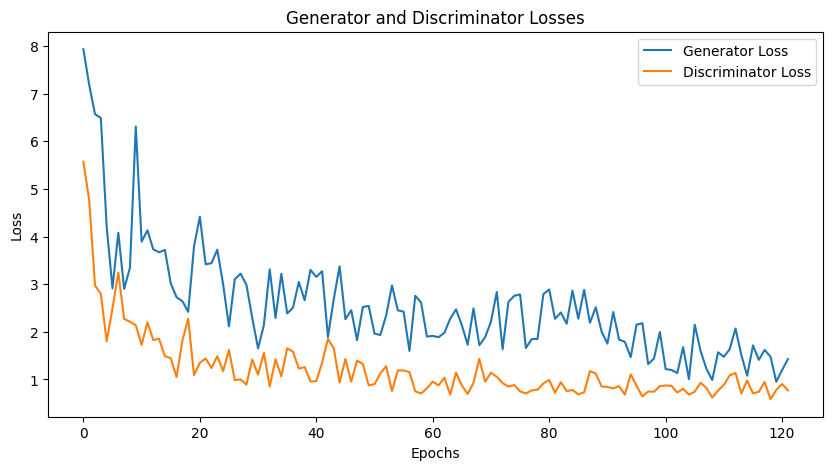

In [26]:
generator_25S, discriminator_25S, X_train_25S, X_test_25S, y_train_25S, y_test_25S =train_model('25S', 2, 64)

# Epochs 2, Batch Size 64-17m32s
# Best threshold:  3.7775551102204408
# Best F1 Score:  0.8540372670807453
# Recall:  0.8675078864353313
# Precision:  0.8409785932721713

3022/3022 [==============================] - 2s 719us/step
Anomaly Scores: [ 0.75408347  0.49933528  0.50286518 ... 22.84278294  2.92291665
 33.21172562]


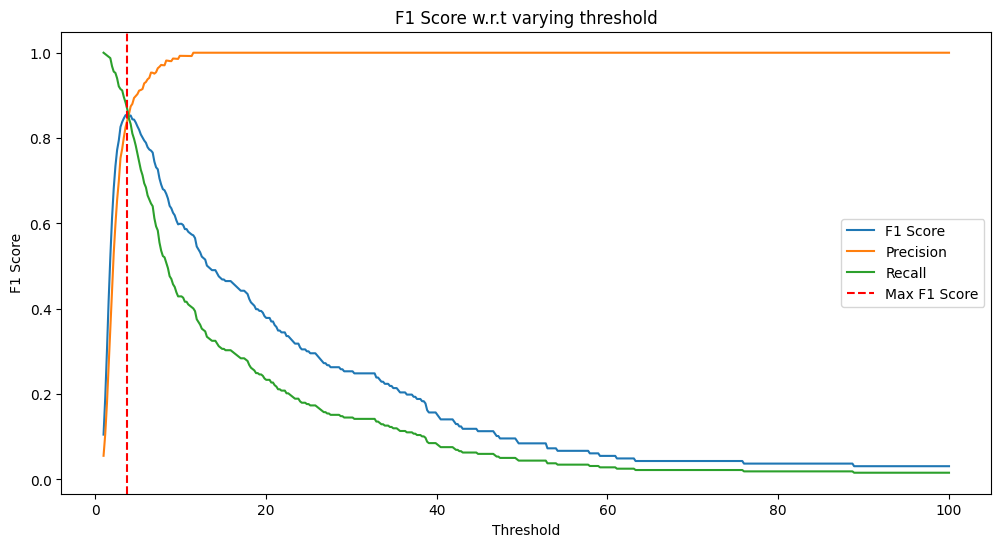

Best threshold:  3.7775551102204408
Best F1 Score:  0.8540372670807453
Recall:  0.8675078864353313
Precision:  0.8409785932721713


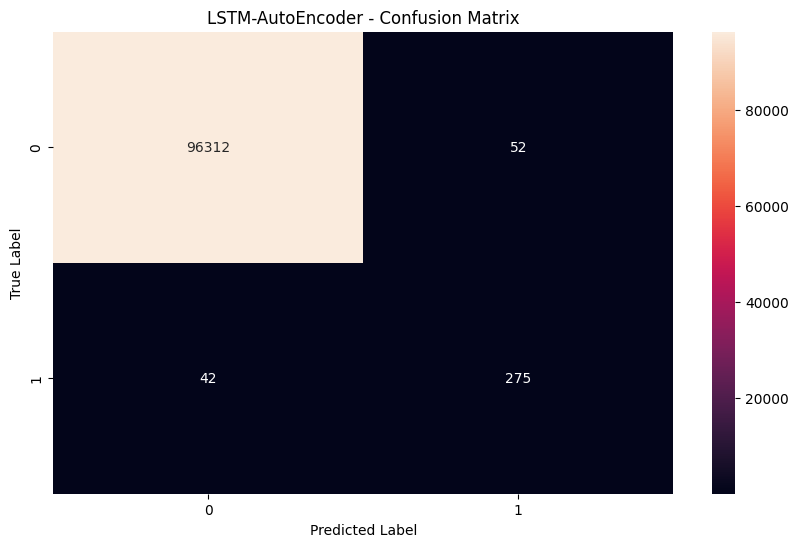

In [27]:
# 使用X_test作为输入，生成正常样本
# 1 为异常，0 为正常
generated_data = generator_25S.predict(X_test_25S)

# 计算输入样本与生成异常样本之间的重构误差作为异常分数 MAE
reconstruction_errors_25S = np.mean(np.abs(generated_data - X_test_25S), axis=1)

# 打印异常分数
print("Anomaly Scores:", reconstruction_errors_25S)

threshold_25S = pick_threshold(y_test_25S, reconstruction_errors_25S)

# 15S

nopump_index:  [48, 149, 156, 180, 224, 264, 299, 300, 330, 331]
nopump_symbol:  ['YOYOW', 'DUSK', 'VIA', 'VIA', 'VIB', 'GXS', 'HC', 'RDN', 'RDN', 'WINGS']
df.shape:  (584104, 16)
(327,)
df_cleaned.shape:  (584081, 16)
(317,)
deleted:  23
Epochs: 1
Number of iterations per epoch: 7297
2/2 [==============================] - 0s 6ms/step
index: 0, g_loss: 10.287368774414062, d_loss: 5.0958147048950195
2/2 [==============================] - 0s 4ms/step
index: 1, g_loss: 11.146318435668945, d_loss: 5.597110748291016
2/2 [==============================] - 0s 3ms/step
index: 2, g_loss: 10.33503532409668, d_loss: 5.01124382019043
2/2 [==============================] - 0s 3ms/step
index: 3, g_loss: 10.005436897277832, d_loss: 4.758401870727539
2/2 [==============================] - 0s 3ms/step
index: 4, g_loss: 10.588174819946289, d_loss: 4.481274604797363
2/2 [==============================] - 0s 3ms/step
index: 5, g_loss: 9.066092491149902, d_loss: 4.577858924865723
2/2 [=====================

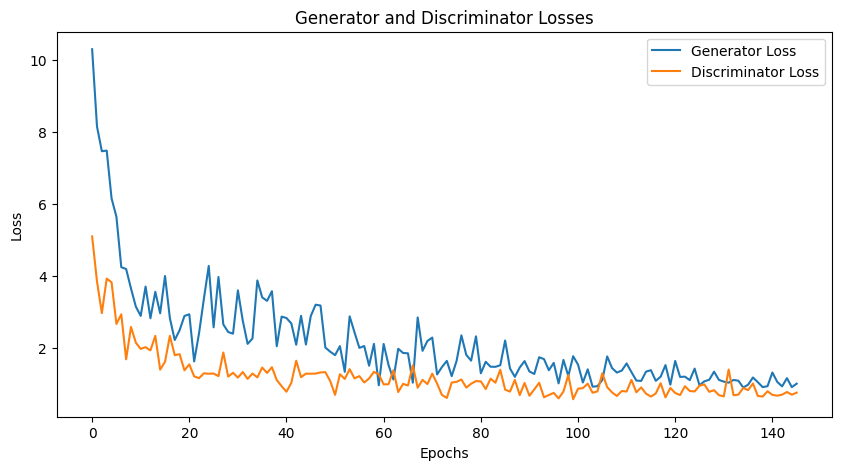

In [28]:
generator_15S, discriminator_15S, X_train_15S, X_test_15S, y_train_15S, y_test_15S =train_model('15S', 2, 64)


# Epochs 2, Batch Size 64-23m32s
# Best threshold:  4.967935871743487
# Best F1 Score:  0.8211243611584328
# Recall:  0.7602523659305994
# Precision:  0.8925925925925926

3659/3659 [==============================] - 3s 865us/step
Anomaly Scores: [ 0.41016197  0.85955156  0.7864757  ... 22.24158646  3.32143588
 33.82622991]


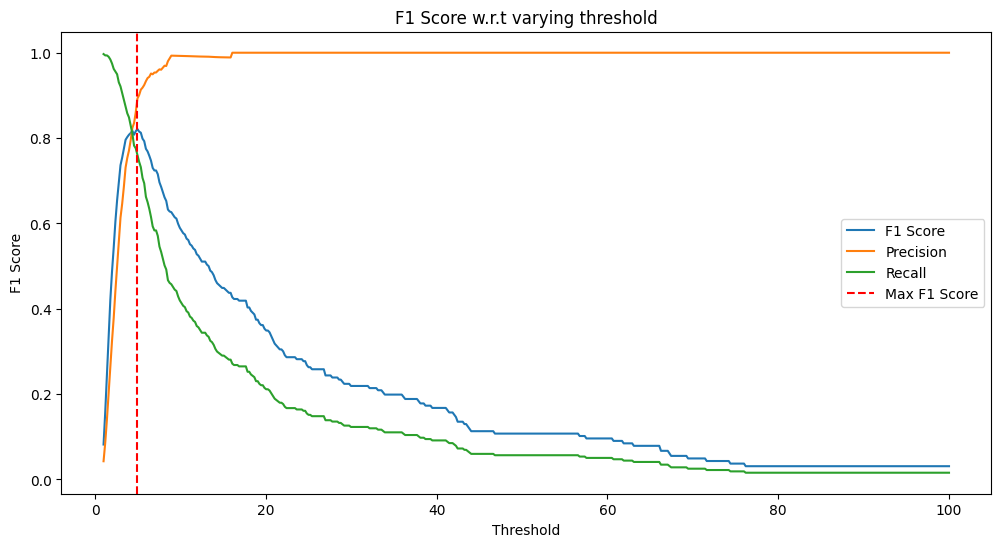

Best threshold:  4.967935871743487
Best F1 Score:  0.8211243611584328
Recall:  0.7602523659305994
Precision:  0.8925925925925926


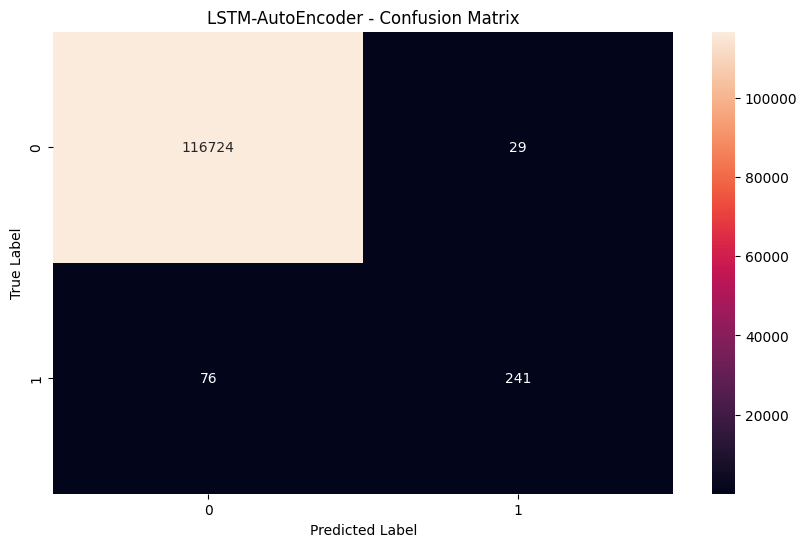

In [29]:
# 使用X_test作为输入，生成正常样本
# 1 为正常，0 为异常
generated_data = generator_15S.predict(X_test_15S)

# 计算输入样本与生成异常样本之间的重构误差作为异常分数 MAE
reconstruction_errors_15S = np.mean(np.abs(generated_data - X_test_15S), axis=1)

# 打印异常分数
print("Anomaly Scores:", reconstruction_errors_15S)

threshold_15S = pick_threshold(y_test_15S, reconstruction_errors_15S)

# 5S

nopump_index:  [48, 149, 156, 180, 224, 264, 300, 327, 330, 331]
nopump_symbol:  ['YOYOW', 'DUSK', 'VIA', 'VIA', 'VIB', 'GXS', 'RDN', 'GRS', 'RDN', 'WINGS']
df.shape:  (821307, 16)
(327,)
df_cleaned.shape:  (821275, 16)
(317,)
deleted:  32
Epochs: 1
Number of iterations per epoch: 10261
2/2 [==============================] - 0s 4ms/step
index: 0, g_loss: 15.424948692321777, d_loss: 7.53781795501709
2/2 [==============================] - 0s 3ms/step
index: 1, g_loss: 15.037298202514648, d_loss: 7.5159759521484375
2/2 [==============================] - 0s 3ms/step
index: 2, g_loss: 14.974469184875488, d_loss: 7.2994704246521
2/2 [==============================] - 0s 3ms/step
index: 3, g_loss: 15.424948692321777, d_loss: 7.536449432373047
2/2 [==============================] - 0s 5ms/step
index: 4, g_loss: 14.709532737731934, d_loss: 7.712935447692871
2/2 [==============================] - 0s 4ms/step
index: 5, g_loss: 15.424948692321777, d_loss: 7.391870498657227
2/2 [===================

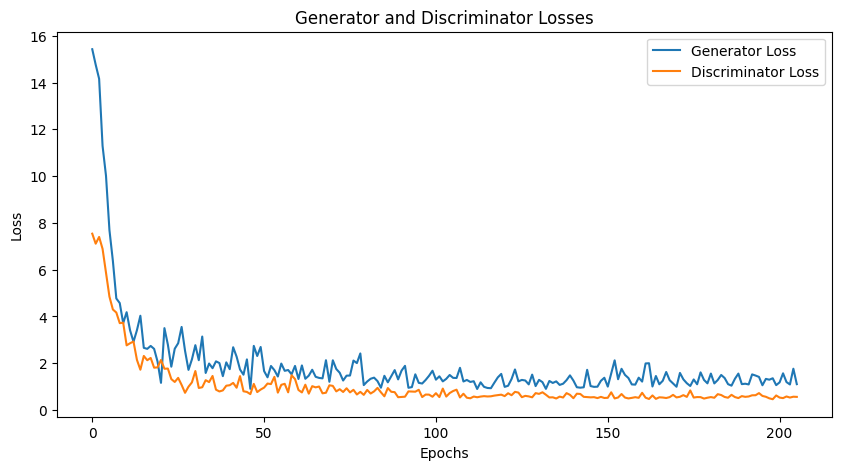

In [30]:
generator_5S, discriminator_5S, X_train_5S, X_test_5S, y_train_5S, y_test_5S =train_model('5S', 2, 64)

5141/5141 [==============================] - 7s 1ms/step
Anomaly Scores: [ 1.44297885  0.61610826  0.61409105 ... 23.20666123  1.870996
 37.56883768]


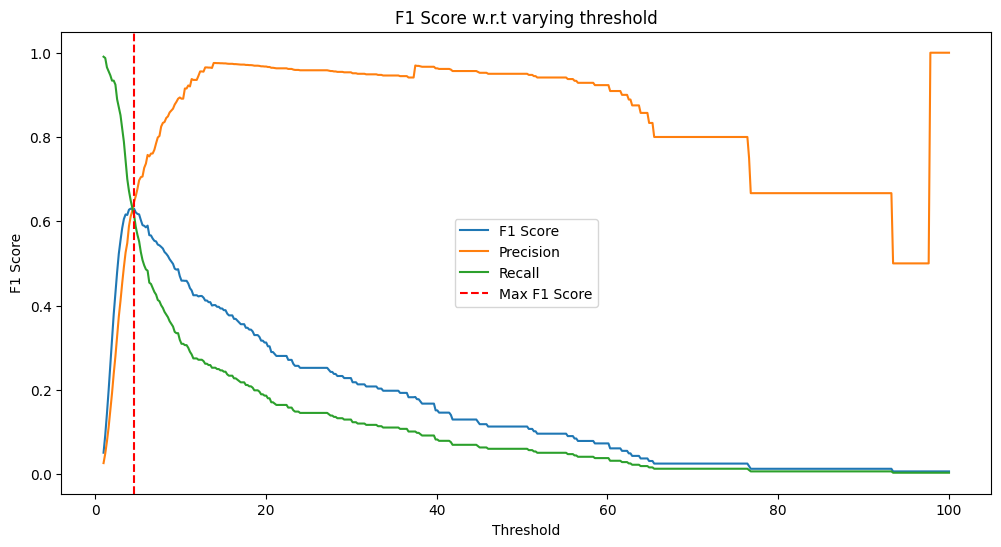

Best threshold:  4.571142284569138
Best F1 Score:  0.6300484652665589
Recall:  0.6151419558359621
Precision:  0.6456953642384106


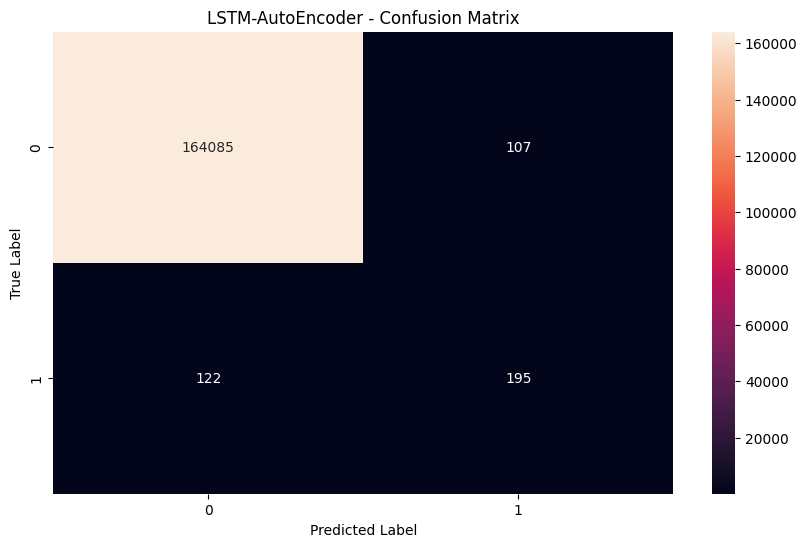

In [31]:
# 使用X_test作为输入，生成正常样本
# 1 为正常，0 为异常
generated_data = generator_5S.predict(X_test_5S)

# 计算输入样本与生成异常样本之间的重构误差作为异常分数 MAE
reconstruction_errors_5S = np.mean(np.abs(generated_data - X_test_5S), axis=1)

# 打印异常分数
print("Anomaly Scores:", reconstruction_errors_5S)

threshold_5S = pick_threshold(y_test_5S, reconstruction_errors_5S)

Reconstruction error threshold_25S:  3.7775551102204408
Reconstruction error threshold_15S:  4.967935871743487
Reconstruction error threshold_5S:  4.571142284569138
5S: F1 Score: 0.6300484652665589, Recall: 0.6151419558359621, Precision: 0.6456953642384106
15S: F1 Score: 0.8211243611584328, Recall: 0.7602523659305994, Precision: 0.8925925925925926
25S: F1 Score: 0.8540372670807453, Recall: 0.8675078864353313, Precision: 0.8409785932721713


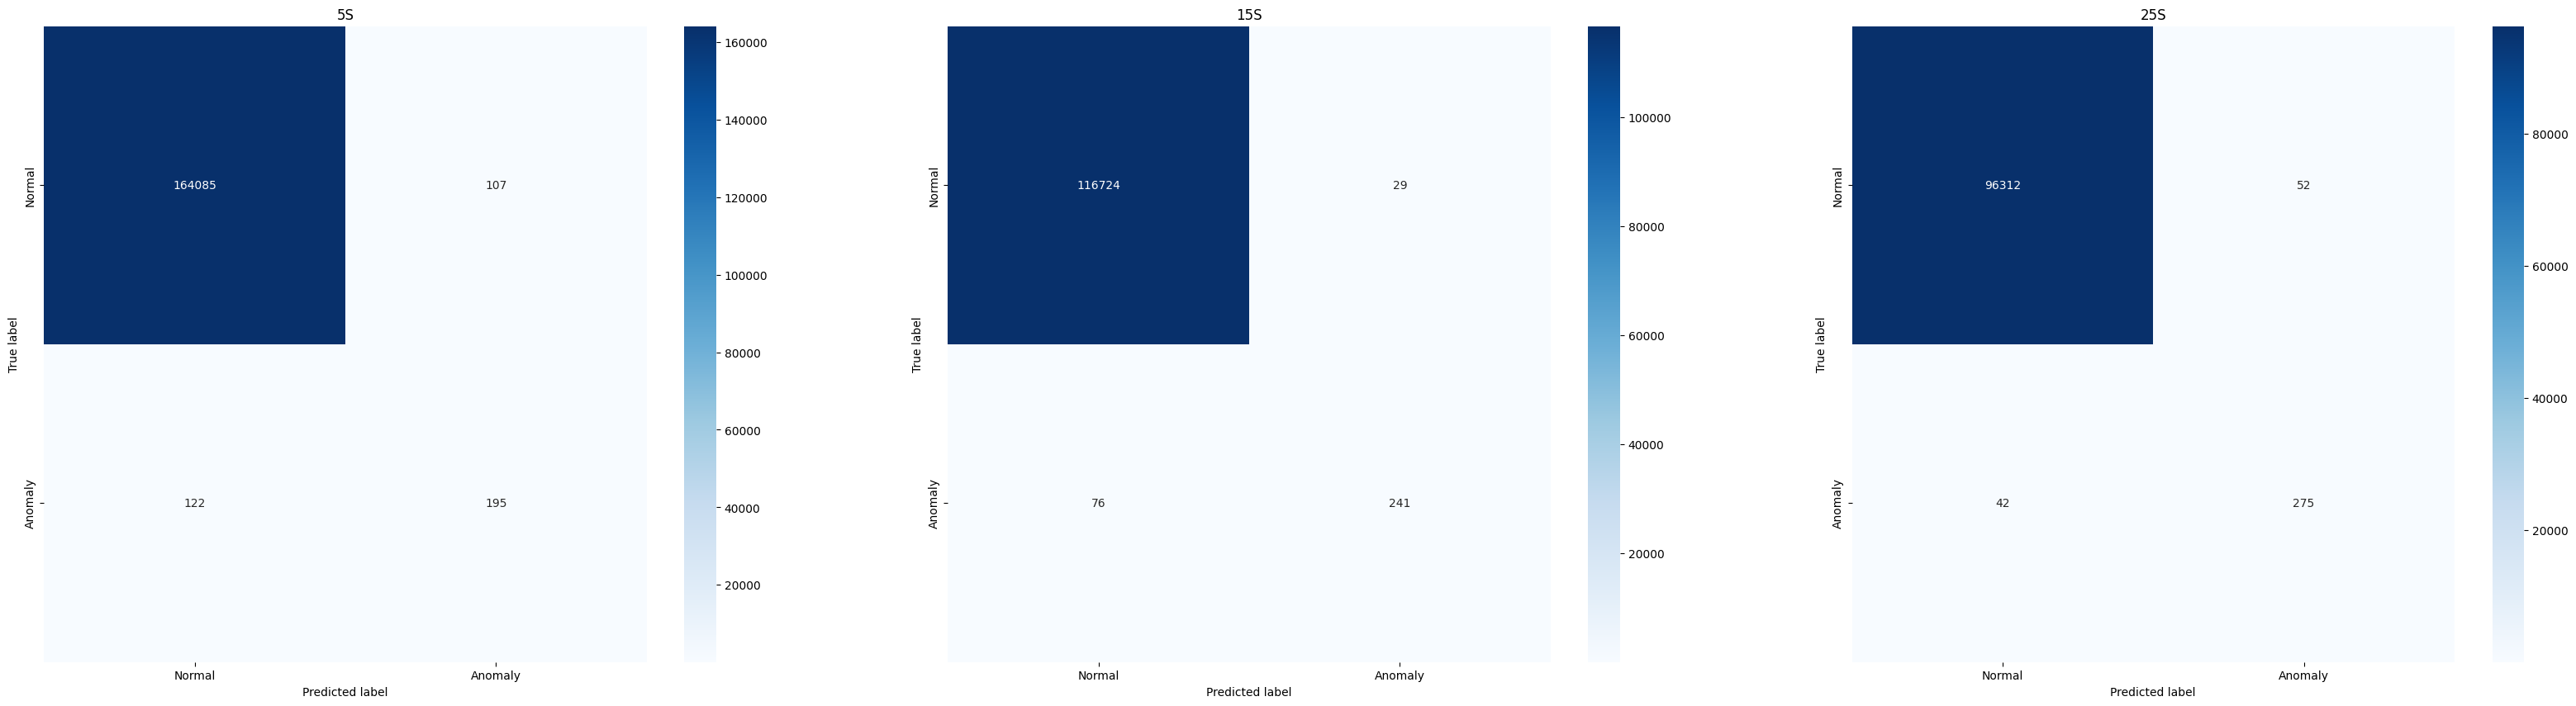

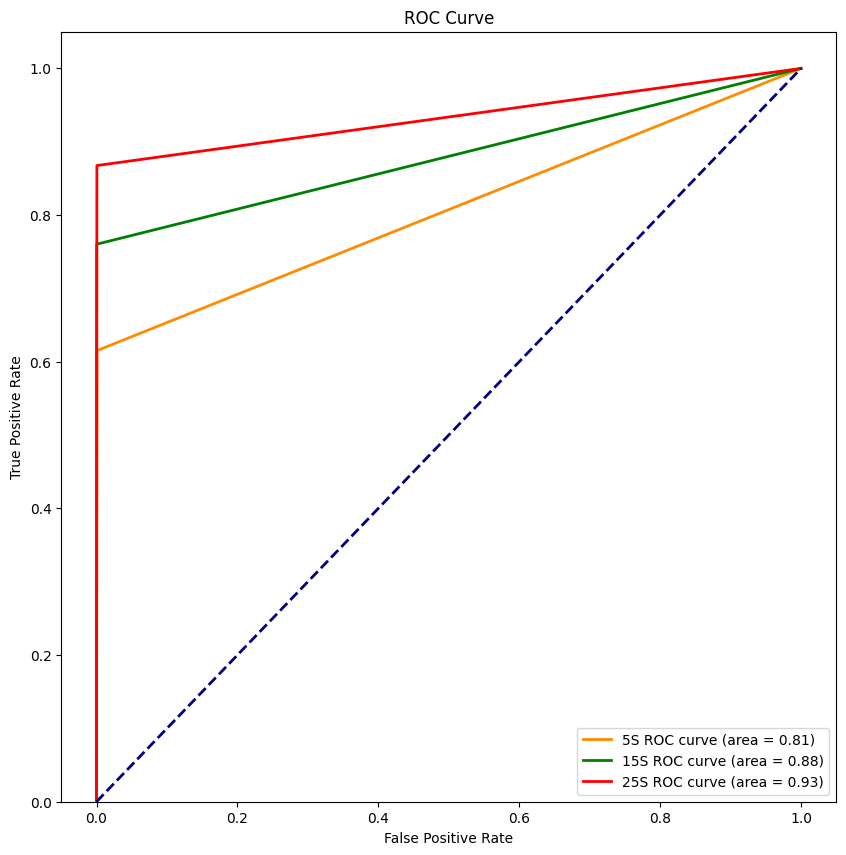

In [34]:
# 设置阈值
print("Reconstruction error threshold_25S: ", threshold_25S)
print("Reconstruction error threshold_15S: ", threshold_15S)
print("Reconstruction error threshold_5S: ", threshold_5S)

y_test_pred_5S = np.where(reconstruction_errors_5S >= threshold_5S , 1, 0)
y_test_pred_15S = np.where(reconstruction_errors_15S >= threshold_15S , 1, 0)
y_test_pred_25S = np.where(reconstruction_errors_25S >= threshold_25S , 1, 0)

# precision, recall, f1-score
from sklearn.metrics import f1_score, recall_score, precision_score
F1_score_5S = f1_score(y_test_5S, y_test_pred_5S)
Recall_5S = recall_score(y_test_5S, y_test_pred_5S)
Precision_5S = precision_score(y_test_5S, y_test_pred_5S)

F1_score_15S = f1_score(y_test_15S, y_test_pred_15S)
Recall_15S = recall_score(y_test_15S, y_test_pred_15S)
Precision_15S = precision_score(y_test_15S, y_test_pred_15S)

F1_score_25S = f1_score(y_test_25S, y_test_pred_25S)
Recall_25S = recall_score(y_test_25S, y_test_pred_25S)
Precision_25S = precision_score(y_test_25S, y_test_pred_25S)

print('5S: F1 Score: {}, Recall: {}, Precision: {}'.format(F1_score_5S, Recall_5S, Precision_5S))
print('15S: F1 Score: {}, Recall: {}, Precision: {}'.format(F1_score_15S, Recall_15S, Precision_15S))
print('25S: F1 Score: {}, Recall: {}, Precision: {}'.format(F1_score_25S, Recall_25S, Precision_25S))

# plot confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix_5S = confusion_matrix(y_test_5S, y_test_pred_5S)
confusion_matrix_15S = confusion_matrix(y_test_15S, y_test_pred_15S)
confusion_matrix_25S = confusion_matrix(y_test_25S, y_test_pred_25S)

plt.figure(figsize=(40,10))
plt.subplot(1,3,1)
plt.title('5S')
sns.heatmap(confusion_matrix_5S, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.subplot(1,3,2)
plt.title('15S')
sns.heatmap(confusion_matrix_15S, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.subplot(1,3,3)
plt.title('25S')
sns.heatmap(confusion_matrix_25S, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted label')
plt.ylabel('True label')


# plot ROC curve
from sklearn.metrics import roc_curve, auc
fpr_5S, tpr_5S, thresholds_5S = roc_curve(y_test_5S, y_test_pred_5S)
roc_auc_5S = auc(fpr_5S, tpr_5S)

fpr_15S, tpr_15S, thresholds_15S = roc_curve(y_test_15S, y_test_pred_15S)
roc_auc_15S = auc(fpr_15S, tpr_15S)

fpr_25S, tpr_25S, thresholds_25S = roc_curve(y_test_25S, y_test_pred_25S)
roc_auc_25S = auc(fpr_25S, tpr_25S)

plt.figure(figsize=(10,10))
plt.plot(fpr_5S, tpr_5S, color='darkorange', lw=2, label='5S ROC curve (area = %0.2f)' % roc_auc_5S) # lw: line width
plt.plot(fpr_15S, tpr_15S, color='green', lw=2, label='15S ROC curve (area = %0.2f)' % roc_auc_15S) # lw: line width
plt.plot(fpr_25S, tpr_25S, color='red', lw=2, label='25S ROC curve (area = %0.2f)' % roc_auc_25S) # lw: line width
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # 画对角线
# plt.xlim([0.0, 1.0]) # x轴范围
plt.ylim([0.0, 1.05]) # y轴范围
plt.xlabel('False Positive Rate') # x轴标签
plt.ylabel('True Positive Rate') # y轴标签
plt.title('ROC Curve') # 图片标题
plt.legend(loc="lower right") # 图例
plt.show()

